In [1]:
import torch
from torch import nn 
from torch.nn import functional as F
import numpy as np
import pandas as pd
# 参考 https://www.kaggle.com/code/nattoli/simple-resnet-resnext-baseline/notebook

In [6]:
# 使用命令行工具下载数据集：
# https://github.com/Kaggle/kaggle-api
# 还需要配置OpenAPI KEY
# https://www.kaggle.com/{user}/account
# !kaggle competitions download -c classify-leaves

In [2]:
data_file = '../data/ch07-30-classify-leaves'
train_file = f'{data_file}/train.csv'
test_file = f'{data_file}/test.csv'

### 查看训练集label

In [3]:
train_label_file = pd.read_csv(train_file)
train_label_file.describe()

,image,label
count,18353,18353
unique,18353,176
top,images/8476.jpg,maclura_pomifera
freq,1,353


### 处理索引和标签

In [4]:
# 对Label去重排序
leave_labels = sorted(list(set(train_label_file['label'])))
label_count = len(leave_labels)
print('Class number: ', label_count)
leave_labels[:10]

Class number:  176


['abies_concolor',
 'abies_nordmanniana',
 'acer_campestre',
 'acer_ginnala',
 'acer_griseum',
 'acer_negundo',
 'acer_palmatum',
 'acer_pensylvanicum',
 'acer_platanoides',
 'acer_pseudoplatanus']

In [5]:
class_to_num = dict(zip(leave_labels, range(label_count)))
# 数字映射到类
num_to_class = {v: k for k, v in class_to_num.items()}


In [6]:
df = pd.read_csv(train_file)
a1 = np.asarray(df.iloc[:, 0:1]).tolist()

In [20]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class LeavesDataset(Dataset):
    def __init__(self, parent, img_path, data_type='train', valid_ratio=0.1) -> None:
        super().__init__()
        self.data_type = data_type
        label_info = pd.read_csv(os.path.join(parent, img_path))
        data_len = len(label_info.index)
        idx_start, idx_end = 0, data_len
        if data_type == 'train':
            idx_start, idx_end = 0, int(data_len * (1 - valid_ratio))
        elif data_type == 'valid':
            idx_start, idx_end = int(data_len * (1 - valid_ratio)), data_len
        print(f'{data_type}[{idx_start}:{idx_end}]')
        self.img_paths = [os.path.join(parent, str(img[0])) for img in np.asarray(label_info.iloc[idx_start:idx_end,0:1])]
        if data_type != 'test':
            self.labels = [class_to_num[str(label[0])] for label in np.asarray(label_info.iloc[idx_start:idx_end,1:2])] 
        if self.data_type == 'train':
            self.transform = transforms.Compose([
                # transforms.RandomResizedCrop((224,224), scale=(0.8, 1), ratio=(0.8, 1.2)), #随机剪裁
                # transforms.transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5), #颜色亮度色调
                # transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(p=0.5),   #随机水平翻转 选择一个概率
                transforms.RandomVerticalFlip(p=0.5),   #随机水平翻转 选择一个概率
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        elif self.data_type == 'valid':
           self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ]) 
        else:
            # valid和test不做数据增强
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

    def __getitem__(self, index):
        img_path = self.img_paths[index]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        if self.data_type == 'test':
            return image
        else:
            return image, self.labels[index] 

    def __len__(self) -> int:
        return len(self.img_paths)

In [19]:
train_dataset = LeavesDataset(data_file, 'train.csv', 'train')
valid_dataset = LeavesDataset(data_file, 'train.csv', 'valid')
test_dataset = LeavesDataset(data_file, 'test.csv', 'test')

batch_size = 16
train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True,num_workers=8)
valid_loader = DataLoader(dataset=valid_dataset,batch_size=batch_size,shuffle=False,num_workers=8)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

# print(len(train_dataset), len(valid_dataset))
#print(num_to_class.keys())
# labels = np.array(valid_dataset.labels)
# len(labels)
# for i in train_loader:
#     img, label = i
#     print(label, [num_to_class[l] for l in label.numpy()])
#     break

# for i in valid_loader:
#     img, label = i
#     print(label, [num_to_class[l] for l in label.numpy()])
#     break

train[0:16517]
valid[16517:18353]
test[0:8800]


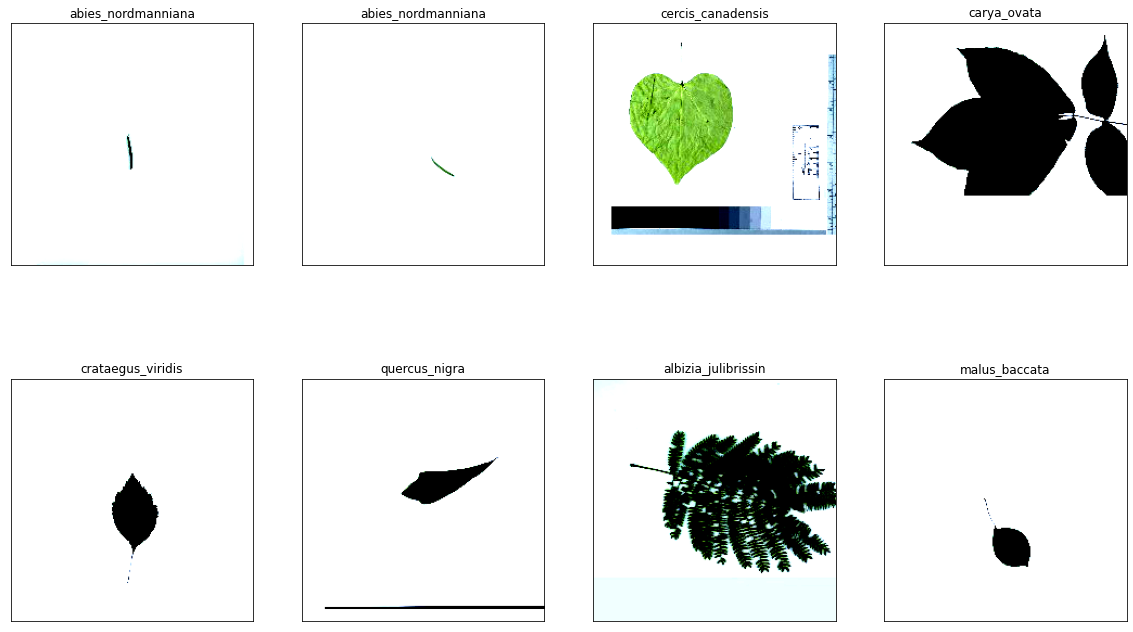

In [21]:
import matplotlib.pyplot as plt

def im_convert(tensor):
    """ 展示数据"""
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image.clip(0, 1)

    return image

fig=plt.figure(figsize=(20, 12))
columns = 4
rows = 2

dataiter = iter(valid_loader)
inputs, classes = dataiter.next()

for idx in range (columns*rows):
    ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
    ax.set_title(num_to_class[int(classes[idx])])
    plt.imshow(im_convert(inputs[idx]))
plt.show()

In [22]:
def try_gpu(index=0):
    if torch.cuda.device_count() > index:
        return torch.device(f'cuda:{index}')
    else:
        return torch.device('cpu')

try_gpu()

device(type='cuda', index=0)

In [11]:
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1Conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        
        if use_1x1Conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        # 使用inplace 更省内存
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            # 1 x 1的卷积层，直接作用在X上
            X = self.conv3(X)
        Y += X
        return F.relu(Y)
blk = Residual(3, 3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [12]:
b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
    """
    input_channels: 输入通道
    num_channels: 输出通道数量
    num_residuals: 残差块数量
    """
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(
                Residual(input_channels, num_channels, use_1x1Conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

net = nn.Sequential(b1, b2, b3, b4, b5, nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(), nn.Linear(512, 176))


In [27]:
# X = torch.rand(size=(1, 1, 224, 224))

# for layer in net:
#     X = layer(X)
#     print(layer.__class__.__name__, 'output shape: \t', X.shape)

loss nan, train acc 0.009, test acc 0.014
655.5 examples/sec on cuda:0


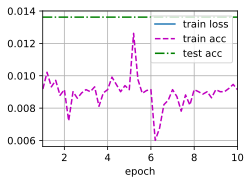

In [35]:
from d2l import torch as d2l
lr, num_epochs, batch_size = 0.1, 10, 512
# train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_loader, valid_loader, num_epochs, lr, d2l.try_gpu())
# train_fine_tuning(net, train_loader, valid_loader, lr, num_epochs=num_epochs, param_group=False)

In [23]:
import torchvision.models as models
# This is for the progress bar.
from tqdm import tqdm
# import seaborn as sns
# 是否要冻住模型的前面一些层
def set_parameter_requires_grad(model, feature_extracting):
#     if feature_extracting:
#         model = model
#         for i, param in enumerate(model.children()):
#             if i == 8:
#                 break
#             param.requires_grad = False
    if feature_extracting:
        model = model
        for param in model.parameters():
            param.requires_grad = False
# resnet34模型
def res_model(num_classes, feature_extract = False, use_pretrained=True):

    model_ft = models.resnet34(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
#     model_ft.fc = nn.Sequential(
#         nn.Linear(num_ftrs, 512),
#         nn.ReLU(inplace=True),
#         nn.Dropout(.3),
#         nn.Linear(512, len(num_to_class))
#     )
    model_ft.fc = nn.Sequential(
        nn.Linear(num_ftrs, num_classes)
    )
    return model_ft      

In [31]:
def get_net(num_class):
    finetune_net = models.resnet34(pretrained=True)
    finetune_net.fc = nn.Linear(finetune_net.fc.in_features, num_class)
    nn.init.xavier_uniform_(finetune_net.fc.weight)
    return finetune_net

In [32]:
model_path = '../data/leaves-rest50.ckpt'

# 如果param_group=True，输出层中的模型参数将使用十倍的学习率
def train_fine_tuning(net, train_iter, test_iter, learning_rate, batch_size=128, num_epochs=5,
                      param_group=True):
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
             if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.Adam([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                   devices)

loss 0.089, train acc 0.970, test acc 0.941
295.5 examples/sec on [device(type='cuda', index=0)]


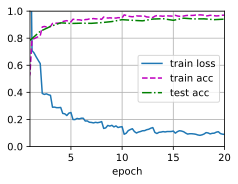

In [33]:
from d2l import torch as d2l
model = get_net(176)
# model = res_model(176)
net = model.to(try_gpu())
lr, num_epochs = 5e-5, 20
train_fine_tuning(net, train_loader, valid_loader, lr, num_epochs=num_epochs)

In [34]:
# model = res_model(176)
# net = model.to(try_gpu())
torch.save(net.state_dict(), model_path)

In [35]:
from tqdm import tqdm
m = get_net(176)
m = m.to(try_gpu())
m.load_state_dict(torch.load(model_path))
m.eval()
# m = net

predictions = []
for batch in tqdm(test_loader):
    imgs = batch
    with torch.no_grad():
        logits = m(imgs.to(try_gpu()))
        predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())

preds = []
for i in predictions:
    preds.append(num_to_class[i])

saveFileName = './submission.csv'

test_data = pd.read_csv(test_file)
test_data['label'] = pd.Series(preds)
submission = pd.concat([test_data['image'], test_data['label']], axis=1)
submission.to_csv(saveFileName, index=False)
print("Done!!!!!!!!!!!!!!!!!!!!!!!!!!!")

100%|██████████| 550/550 [00:09<00:00, 56.38it/s]


Done!!!!!!!!!!!!!!!!!!!!!!!!!!!
